<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
## This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data

### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import sys, os

### Brain Observatory Set up

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

#Set manifest path when outside of AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'
manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


## Computing a spatial receptive field

In [3]:
cell_id = 541513716

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We'll use a similar function to get the dff_trace and the stimulus table as we did for the tuning curve example. This time it will also return the stimulus template - an array of each frame of the stimulus movie.
</div>

In [4]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus):    
    print "Downloading cell_specimens. This will take a moment the first time it is run."
    cell_specimens = pd.DataFrame(boc.get_cell_specimens())
    expt_id = cell_specimens[cell_specimens.cell_specimen_id==cell_specimen_id].experiment_container_id.values[0]
    session_id = boc.get_ophys_experiments(stimuli=[stimulus],experiment_container_ids=[expt_id])[0]['id']
    print "Opening NWB file for ophys session. This will take several minutes if the file isn't downloaded yet."
    data_set = boc.get_ophys_experiment_data(session_id)
    print "Done"
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]
    stim_table = data_set.get_stimulus_table(stimulus)
    stim_template = data_set.get_stimulus_template(stimulus)
    return (timestamps, dff_trace, stim_table, stim_template)

In [6]:
timestamps, dff_trace, stim_table, stim_template = get_dff_traces_and_stim_table(cell_id, 'locally_sparse_noise')

Opening NWB file for ophys session. This will take several minutes if the file isn't downloaded yet.
Done


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Again, let's look at our fluorescence trace and stimulus table</div>

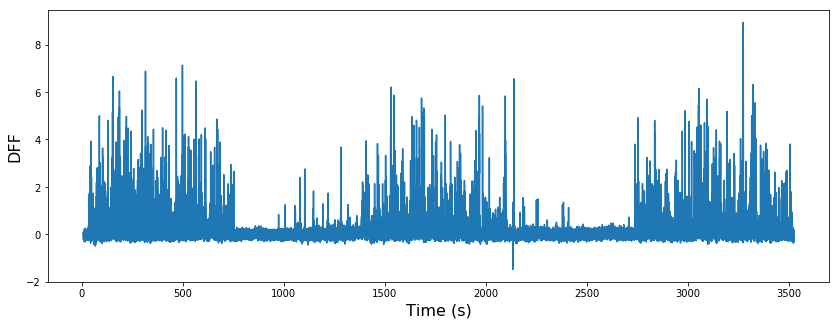

In [7]:
plt.figure(figsize=(14,5))
plt.plot(timestamps, dff_trace)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("DFF", fontsize=16)

In [8]:
stim_table.head()

,frame,start,end
0,0,735,742
1,1,743,750
2,2,750,757
3,3,758,765
4,4,765,772


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table for the Locally Sparse Noise stimulus has much less information than the one for the Drifting Gratings. This stimulus is essentially a movie, and the table tells us the start and end time (in 2P acquisition frames) of the presentation of each movie frame. In order to compute this spatial receptive field, however, we need to know what each movie frame was. This is also contained in the NWB file in the form of the **stimulus template**.


Below is a function to use the SDK to get the stimulus template. This returns a 3D numpy array (t,y,x).
</div>

In [11]:
def get_stim_template(cell_specimen_id, stimulus):    
    cell_specimens = pd.DataFrame(boc.get_cell_specimens())
    expt_id = cell_specimens[cell_specimens.cell_specimen_id==cell_specimen_id].experiment_container_id.values[0]
    session_id = boc.get_ophys_experiments(stimuli=[stimulus],experiment_container_ids=[expt_id])[0]['id']
    data_set = boc.get_ophys_experiment_data(session_id)
    stim_template = data_set.get_stimulus_template(stimulus)
    return (stim_template)

In [12]:
stim_template = get_stim_template(cell_id, 'locally_sparse_noise')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Let's get a feel for this stimulus. First, look at the shape of the template.  
</div>

In [9]:
stim_template.shape

(9000, 16, 28)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
There are 9000 frames each with dimension 28 X 16.  

Now, look at a single frame of the template.
</div>

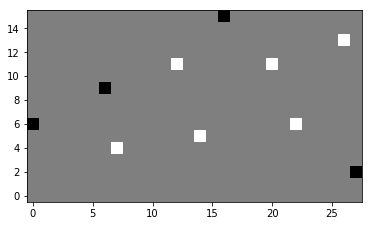

In [10]:
plt.imshow(stim_template[133,:,:], cmap='gray', interpolation='none', origin='lower')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Each frame is populated with a small number of white and black squares on a gray background. The <b>frame</b> values in the stimulus table refer to the frames of this stimulus template.
</div>

## Computing a spatial receptive field

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The method we are going to use to calculate the spatial receptive field is very similar to the method we used to calculate a orientation tuning curve. For each location in space, we want to quantify the mean response to the presence of a white spot and the presence of a black spot. We'll start by computing the mean response to each stimulus frame, and then average across frames that have spots in the same location. 

<p><p>Now, in the drifting grating stimulus we looked at before, each grating was presented for 2 seconds, with 1 second of gray in between trials.  This locally sparse noise stimulus is different. Each frame is presented for 0.25 seconds before the next frame is presented. There is no gray period in between.  The dynamics of the calcium indicator are such that the cell's response is hard to discern during that 0.25 seconds, so in quantifying the cell's response to a given frame, you'll want to integrate over a slightly larger time window.  Each stimulus frame is presented for 7 acquisition frames.  I recommend using the mean across 10 or 14 frames after the start of a stimulus.
</div>

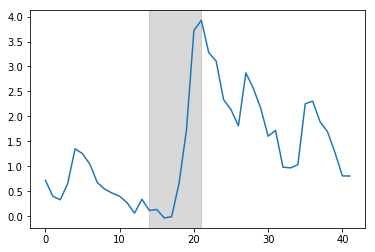

In [11]:
i=50
plt.plot(dff_trace[stim_table.start[i]-14:stim_table.start[i]+28])
plt.axvspan(14,21, color='gray', alpha=0.3)

In [12]:
cell_response= np.zeros((len(stim_table),2))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.frame[i]
    cell_response[i,1] = dff_trace[stim_table.start[i]:stim_table.start[i]+14].mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Next we want to look at each (x,y) location of our stimulus template and average the responses to the trials when there is a white square in that location (on) and separately average the responses to the trials when there is a black square. Create two arrays the size of the stimulus grid to store these responses. Then iterate through the x,y positions and find the trials where that position is occupied by a white square (eg. template==255) or a black square (template==0).  Note, the full stimulus template is not displayed and gets cut off.  Compare the length of the stimulus table and the stimulus template. When finding the trials when the stimulus template is white (or black) in a given location, limit this to only the trials that are actually included in the stimulus table.

In [15]:
on_response = np.zeros((16,28))
off_response = np.zeros((16,28))

In [16]:
for i in range(16):
    for j in range(28):
        trials = np.where(stim_template[:,i,j]==255)[0]
        trials = trials[trials<len(stim_table)]
        on_response[i,j] = cell_response[trials,1].mean()
        trials = np.where(stim_template[:,i,j]==0)[0]
        trials = trials[trials<len(stim_table)]
        off_response[i,j] = cell_response[trials,1].mean()

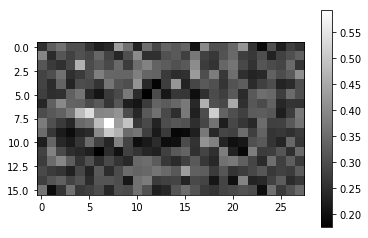

In [17]:
plt.imshow(on_response,cmap='gray', interpolation='none')
plt.colorbar()

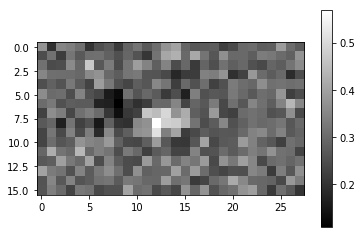

In [18]:
plt.imshow(off_response,cmap='gray', interpolation='none')
plt.colorbar()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Compute receptive fields for these cells: 589212793, 589212793, 541512481, 541511687, 541512607, 541512001, 541512508, 541513594.  In what ways are they similar, in what ways are they different?